In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.gridspec as gridspec
import pymc as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pylab as pl
import scipy as sp
import pymc.graph
from graphviz import Digraph
import pydot
from IPython.display import Image
import pandas as pd

Couldn't import dot_parser, loading of dot files will not be possible.


In [69]:
def mcmc_to_dataframe(mcmc):
    df1 = pd.DataFrame(data=[s.trace.gettrace() if len(s.trace.gettrace().shape)==1 else s.trace.gettrace()[:,0] for s in mcmc.variables])
    df2 = df1.T
    df2.columns = [s.trace.name for s in mcmc.variables]
    return df2

def print_columns(*df):
        for d in df:
            for c in d.columns:
                print c



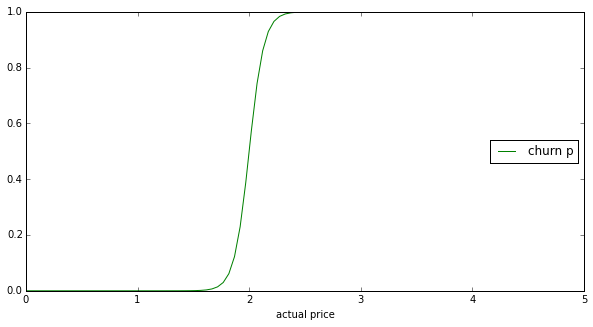

In [3]:
compalints = np.linspace(0, 5,100)
def churn_prob(num_complaints):
    return 1/(1+np.exp(30-15*num_complaints))

ch_p = churn_prob(compalints)

figsize(10,5)
plt.subplot(1,1,1)
plt.plot(compalints, ch_p, 'g',label='churn p')
plt.xlabel("actual price")
plt.legend(loc='right')

In [4]:
N = 1
total_int_calls_minutes_dist = pm.HalfNormal("total_int_calls_minutes_dist", tau=1.0/10000, size=N)
total_int_calls_minutes = pm.Lambda('total_int_calls_minutes', lambda tm=total_int_calls_minutes_dist: 50+tm) 
# intl_calls_price_per_min = pm.Lognormal("intl_calls_price_per_min",mu=0.0, tau=10.0, size=N)

no_pack_ppm = 2
intl_pack_list = [(0,'no_pack',0,no_pack_ppm), (1,'pack50',50,1), (2,'pack150',150,0.8), (3,'pack225',225,0.6), (4,'pack400',400,0.4)]
intl_pack_labels = map(lambda p: p[1],intl_pack_list)

# init_pack_dist = [.2, .2, .2, .2, .2]
# init_pack_dist = [.6, .1, .1, .1, .1]
init_pack_dist = [.8, .05, .05, .05, .05]
intl_pack_id = pm.Categorical("intl_pack_id",init_pack_dist, size=N)

def get_act_price(total_min, pack_min, pack_ppm):
    pack_charge = pack_min*pack_ppm
    over_pack_charge = max(0,total_min - pack_min)*no_pack_ppm
    act_price = (pack_charge+over_pack_charge)/max(1,total_min) 
    return act_price


def price_complaints(act_price, total_min):    
#     return np.maximum(0.01,np.log(act_price*10))
#     return np.maximum(0.01,np.log(act_price*total_min/10))
    return np.maximum(0.01,np.log(np.minimum(act_price*total_min, act_price*5)))

def churn_prob(num_complaints):
#     return 1 if num_complaints > 1.9 else 0
#     return 1/(1+np.exp(7-3*num_complaints))
    return 1/(1+np.exp(30-15*num_complaints))

price_complaints_number_before = pm.Lambda('price_complaints_number_before', \
                                           lambda total_min=total_int_calls_minutes, \
                                                   curr_pack_id=intl_pack_id,  \
                                                   pack_list=intl_pack_list:\
                                            price_complaints(get_act_price(total_min, intl_pack_list[curr_pack_id][2], intl_pack_list[curr_pack_id][3]), total_min))

is_offered = pm.Bernoulli("is_offered", p=0.5, size=N)

@pm.deterministic
def package_offer(offer=is_offered, total_min=total_int_calls_minutes, curr_pack_id=intl_pack_id, pack_list=intl_pack_list):    
    curr_pack = pack_list[curr_pack_id]    
    if(offer):
        packs_calc = map(lambda pack: (pack, get_act_price(total_min, pack[2], pack[3])),pack_list)
        curr_pack = min(packs_calc, key = lambda x: x[1])[0]        
    return curr_pack

@pm.deterministic
def intl_actual_price_per_min(curr_pack=package_offer, total_min=total_int_calls_minutes, pack_list=intl_pack_list):
    real_price_ratio = get_act_price(total_min, curr_pack[2], curr_pack[3])
    return real_price_ratio


price_complaints_number_after = pm.Lambda('price_complaints_number_after', lambda act_price=intl_actual_price_per_min, total_min=total_int_calls_minutes:  price_complaints(act_price, total_min))

    


# churn_p_before = pm.Lambda('churn_p_before', lambda nc=price_complaints_number_before: churn_prob(nc))
# is_churn_before = pm.Bernoulli("is_churn_before",churn_p_before,size=N) 
churn_p = pm.Lambda('churn_p', lambda nc=price_complaints_number_after: churn_prob(nc))
is_churn = pm.Bernoulli("is_churn",churn_p,size=N) 

    

    
    
        


#GENERATE DATA

In [5]:
model = pm.Model([total_int_calls_minutes,
#                   intl_calls_price_per_min,
#                   intl_pack_list,
                  intl_pack_id,
                  price_complaints_number_before,
                  is_offered,
                  package_offer,                  
                  intl_actual_price_per_min,
                  price_complaints_number_after,
                  churn_p,
                  is_churn
                 ])

mcmc = pm.MCMC(model)
mcmc.sample(20000,500)

 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 sec

In [6]:
init_pack = mcmc.trace('intl_pack_id')[:,0]
offered = mcmc.trace('is_offered')[:,0]
calls_minutes = mcmc.trace('total_int_calls_minutes')[:,0]
act_ppm = mcmc.trace('intl_actual_price_per_min')[:]
complaints_before = mcmc.trace('price_complaints_number_before')[:]
complaints_after = mcmc.trace('price_complaints_number_after')[:]
pack_offer = mcmc.trace('package_offer')[:,0]
churn_p =mcmc.trace('churn_p')[:]
churn =mcmc.trace('is_churn')[:,0]


In [7]:
%matplotlib inline

xx = pymc.graph.dag(model)
# xx.write_png('model_graph.png', prog='dot')


Image('model_graph.png')

##ANALIZE GENERATED DATA

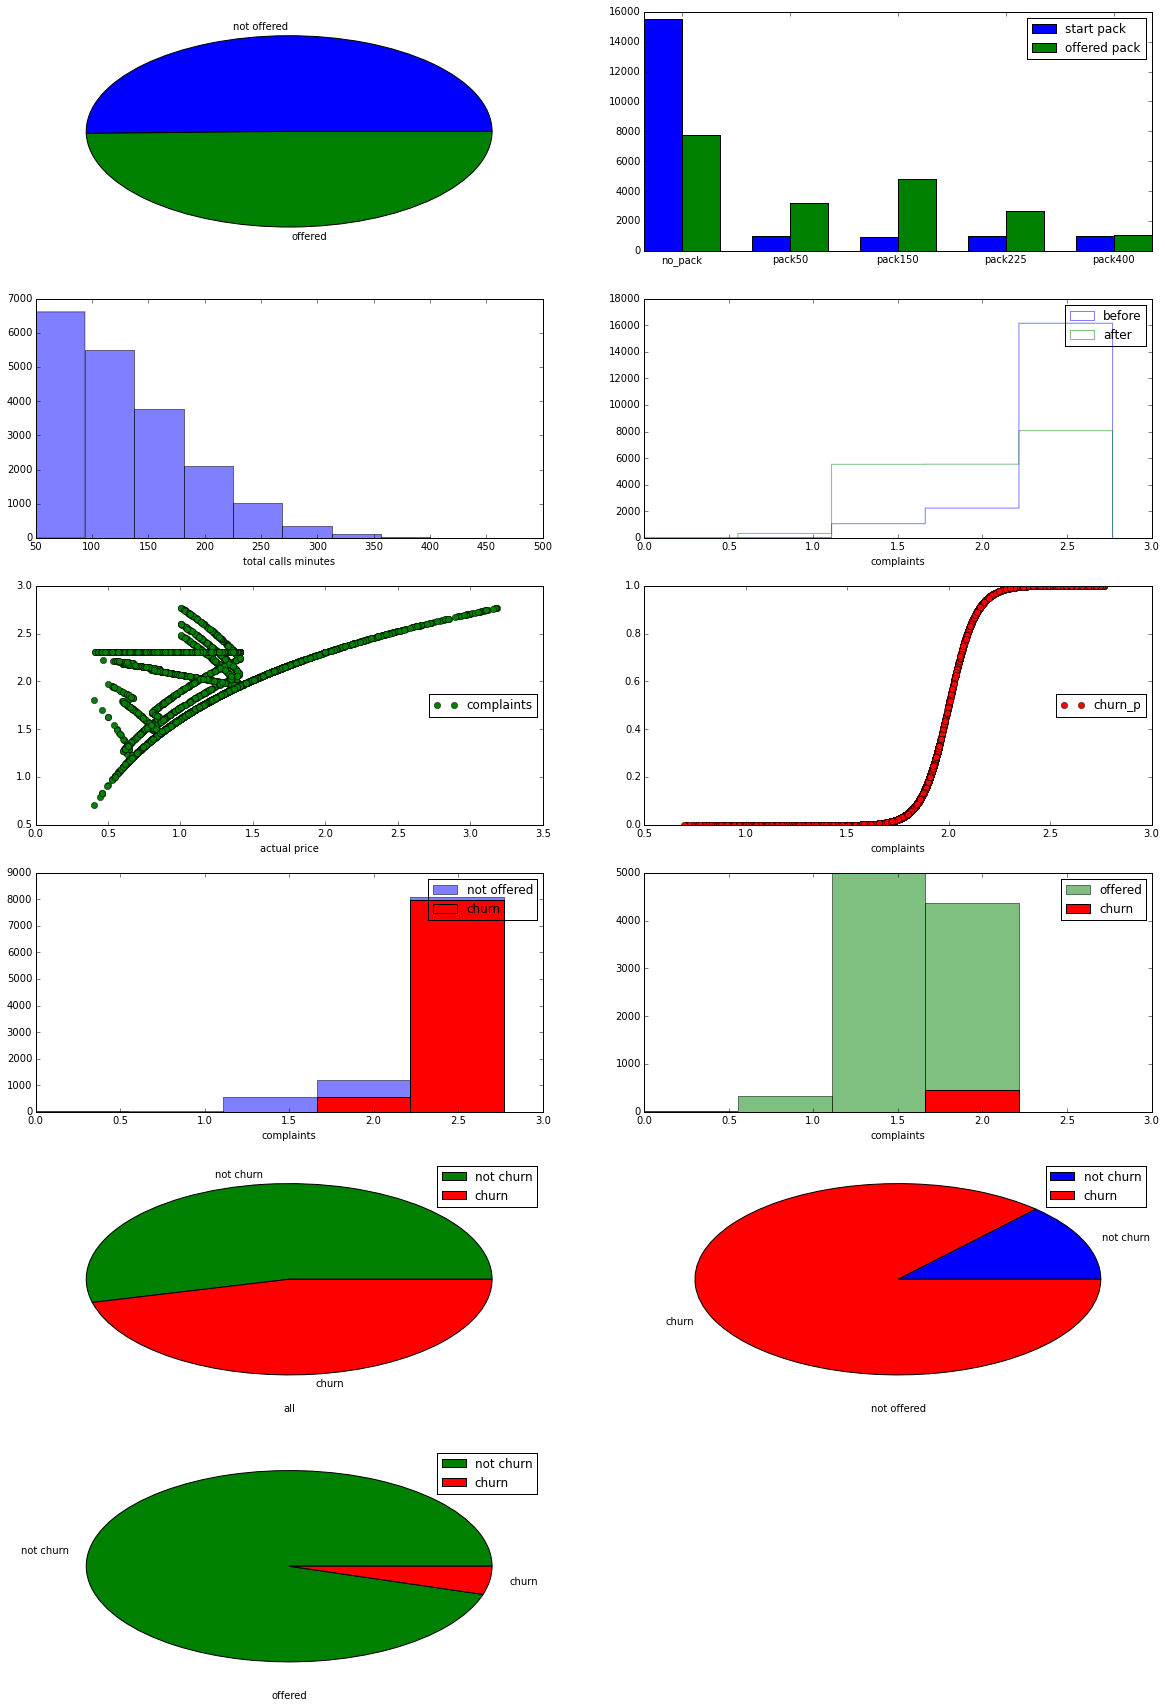

In [8]:
# {'bar', 'barstacked', 'step',  'stepfilled'}
figsize(20,30)
NN=5000
rows = 6
cols =2
i = range(1,cols*rows)
i.reverse()

complaints_bins = np.linspace(0, max(complaints_before),6)


plt.subplot(rows, cols,i.pop())
plt.pie(np.histogram(offered, bins=2)[0], labels=['not offered', 'offered'])


plt.subplot(rows,cols,i.pop())
index = np.arange(len(intl_pack_labels))
bar_width = 0.35
plt.xticks(index + bar_width, intl_pack_labels)
plt.bar(index, sp.stats.itemfreq(init_pack)[:,1].astype(int),bar_width,label='start pack')
plt.bar(index+bar_width, sp.stats.itemfreq(pack_offer)[:,1].astype(int),bar_width,label='offered pack',color='g')
plt.legend(loc='upper right')

# plt.subplot(rows,cols,i.pop())
# plt.hist(complaints_before[~offered], bins=complaints_bins, alpha=0.5, label='not offered',histtype='bar')
# plt.hist(complaints_before[offered], bins=complaints_bins, alpha=0.5, label='offered', histtype='bar')
# plt.xlabel("complaints before")
# plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.hist(calls_minutes, bins=10, alpha=0.5, label='count',histtype='bar')
plt.xlabel('total calls minutes')


plt.subplot(rows,cols,i.pop())
plt.hist(complaints_before, bins=complaints_bins, alpha=0.5, label='before',histtype='step')
plt.hist(complaints_after, bins=complaints_bins, alpha=0.5, label='after', histtype='step')
plt.xlabel("complaints")
plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.plot(act_ppm, complaints_before, 'og',label='complaints')
plt.xlabel("actual price")
plt.legend(loc='right')


plt.subplot(rows,cols,i.pop())
plt.plot(complaints_after, churn_p, 'or',label='churn_p')
plt.xlabel("complaints")
plt.legend(loc='right')

# plt.subplot(rows,cols,i.pop())
# plt.hist(complaints_after[~offered], bins=complaints_bins, alpha=0.5, label='not offered',histtype='bar')
# plt.hist(complaints_after[offered], bins=complaints_bins, alpha=0.5, label='offered', histtype='bar')
# plt.xlabel("complaints after")
# plt.legend(loc='upper right')



# ax1 = plt.subplot(rows,cols,i.pop())
# h1=ax1.hist(complaints_after[churn], bins=complaints_bins, alpha=0.5, label='churn', histtype='bar', color='red')
# h2=ax1.hist(complaints_after[~churn], bins=complaints_bins, alpha=0.5, label='not churn',histtype='bar')
# ax1.set_xlabel("complaints")
# ax1.legend(loc='upper right')
# ax2 = ax1.twinx()
# l1=ax2.plot(complaints_after, churn_p, '.r',label='churn_p')
# ax2.set_ylabel('churn_p')
# ax2.legend(loc='right')





plt.subplot(rows,cols,i.pop())
plt.hist(complaints_after[~offered], bins=complaints_bins, alpha=0.5, label='not offered',histtype='bar', color='b')
plt.hist(complaints_after[churn & ~offered], bins=complaints_bins, alpha=1, label='churn', histtype='bar', color='r')
plt.xlabel("complaints")
plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.hist(complaints_after[offered], bins=complaints_bins, alpha=0.5, label='offered',histtype='bar', color='g')
plt.hist(complaints_after[churn & offered], bins=complaints_bins, alpha=1, label='churn', histtype='bar', color='red')
plt.xlabel("complaints")
plt.legend(loc='upper right')


# plt.subplot(rows,cols,i.pop())
# plt.hist(complaints_after[churn & offered], bins=1, alpha=0.2, label='churn offered', histtype='bar', color='green')
# plt.hist(complaints_after[churn & ~offered], bins=1, alpha=0.2, label='churn not offered',histtype='bar', color='blue')

plt.subplot(rows,cols,i.pop())
plt.pie(np.histogram(churn, bins=2)[0], labels=['not churn', 'churn'], colors=['g','r'])
plt.xlabel("all")
plt.legend(loc='upper right')

plt.subplot(rows,cols,i.pop())
plt.pie(np.histogram(churn[~offered], bins=2)[0], labels=['not churn', 'churn'], colors=['b','r'])
plt.xlabel("not offered")
plt.legend(loc='upper right')

plt.subplot(rows,cols,i.pop())
plt.pie(np.histogram(churn[offered], bins=2)[0], labels=['not churn', 'churn'], colors=['g','r'])
plt.xlabel("offered")
plt.legend(loc='upper right')




# plt.subplot(rows,cols,i.pop())
# plt.hist(pack_offer,50,label='after pack')
# plt.legend(loc='lower right')



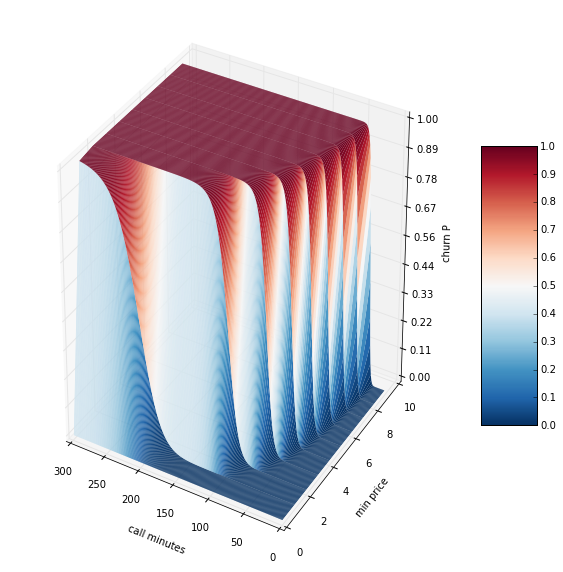

In [56]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from numpy import exp,arange, argsort
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

def price_complaints(act_price, total_min):
#     return act_price*total_min
#     return np.log(act_price*total_min)
#     return np.maximum(0.01,np.log(act_price*total_min/20))
    return np.maximum(0.01,np.log(np.minimum(act_price*total_min/30, act_price*5)))



N = 50000
# call_minutes = pm.rhalf_normal(tau=1.0/10000, size=N)
call_minutes = arange(0,300, 1)
min_price = arange(0.01,10, 1)
X,Y = meshgrid(call_minutes, min_price) # grid of point

# points = zip(calls_minutes, act_ppm)
# sorted_points = np.sort(points)
# new_xs = [point[0] for point in sorted_points]
# new_ys = [point[1] for point in sorted_points]
# X,Y = meshgrid(new_xs[:500], new_ys[:500]) 

Z = churn_prob(price_complaints(X, Y)) # evaluation of the function on the grid

fig = plt.figure(figsize(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu_r,linewidth=0, antialiased=True)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.invert_xaxis()
# ax.invert_zaxis()
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('call minutes')
ax.set_ylabel('min price')
ax.set_zlabel('churn P')

# plt.show()

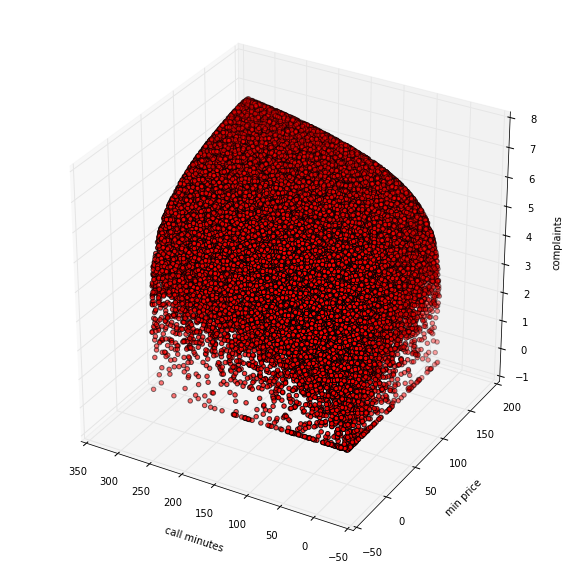

In [10]:

N = 50000
# call_minutes = pm.rhalf_normal(tau=1.0/10000, size=N)
call_minutes = pm.runiform(0,300, size=N)
min_price = pm.runiform(0.01,160, size=N)
compl = [price_complaints(m,p) for m,p in zip(call_minutes,min_price)]

fig = plt.figure(figsize(10,10))
ax = fig.add_subplot(111, projection='3d')

xs = call_minutes
ys = min_price
zs =compl


ax.scatter(xs, ys, zs, zdir=u'z', c='r', marker='o')

ax.invert_xaxis()
ax.set_xlabel('call minutes')
ax.set_ylabel('min price')
ax.set_zlabel('complaints')

plt.show()

#TRAIN MODEL

In [11]:
print(__doc__)
import pandas as pd
from patsy import dmatrices
import scipy as sc
import scipy.optimize as opt
import statsmodels.api as sm

from sklearn.pipeline import Pipeline
from sklearn.datasets import samples_generator
from sklearn import datasets

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_extraction import DictVectorizer
import sklearn.feature_extraction as fe

import sklearn.feature_selection as fs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold

import sklearn.linear_model as lm
import sklearn.grid_search as gs

import sklearn.preprocessing as preprocessing
import sklearn.cross_validation as cv
from sklearn.cross_validation import train_test_split


Automatically created module for IPython interactive environment


##PREPARE DATA

In [89]:
df_raw = mcmc_to_dataframe(mcmc)
df_raw.rename(columns={'package_offer': 'intl_package','price_complaints_number_after':'price_complaints_number'}, inplace=True)
df_raw.drop(['churn_p','intl_pack_id','price_complaints_number_before','total_int_calls_minutes_dist','is_offered'], axis=1, inplace=True)

In [90]:
df_raw.head()      

,total_int_calls_minutes,intl_package,price_complaints_number,intl_actual_price_per_min,is_churn
0,51.39578,1,1.636233,1.027157,False
1,87.32611,2,1.92728,1.374159,False
2,205.659,3,1.188493,0.6564264,False
3,98.56299,2,1.806234,1.217496,False
4,74.69627,1,1.895085,1.330623,True


In [92]:
df_Y = df_raw[['is_churn']]
# df_num_raw = df_raw[['total_int_calls_minutes','price_complaints_number_after','intl_actual_price_per_min']]
df_num_raw = df_raw[['total_int_calls_minutes']]
df_cat_raw = df_raw[['intl_package']]
# df_raw = df_raw.drop(['total_int_calls_minutes_dist','is_offered','price_complaints_number_before', 'intl_pack_id','churn_p'],1)
                
print_columns(df_num_raw, df_cat_raw,df_Y)

total_int_calls_minutes
intl_package
is_churn


In [93]:
#PREPARE CATEGORICAL FEATURES
cat_dict = df_cat_raw.T.to_dict().values()
dvec = DictVectorizer(sparse=False)
cat_vec = dvec.fit_transform(cat_dict)
df_cat = pd.DataFrame(cat_vec, columns=dvec.feature_names_)



In [94]:
#COMPOSE FEATURE MATRIX
df_X = pd.concat([df_num_raw, df_cat], axis=1)
# df_X = pd.concat([df_num_raw[['total_int_calls_minutes']]], axis=1)
# df_X = pd.concat([df_num_raw], axis=1)
print_columns(df_X)
df_X = df_X.astype(float)

total_int_calls_minutes
intl_package=0
intl_package=1
intl_package=2
intl_package=3
intl_package=4


In [95]:
df_X.head()

,total_int_calls_minutes,intl_package=0,intl_package=1,intl_package=2,intl_package=3,intl_package=4
0,51.395776,0,1,0,0,0
1,87.326110,0,0,1,0,0
2,205.659001,0,0,0,1,0
3,98.562989,0,0,1,0,0
4,74.696274,0,1,0,0,0


In [96]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
df_X = poly.fit_transform(df_X)

In [97]:
#SPLIT DATA TO TRAIN/TEST
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y)
Y_train, Y_test = np.ravel(Y_train).astype(float), np.ravel(Y_test).astype(float)



In [98]:
Y_train.mean(), Y_test.mean()

(0.46153846153846156, 0.45948717948717949)

In [99]:
#STANDARTIZE DATA (SCALE DATA TO STANDART NORMAL DISTRIBUTION)
std_scaler = preprocessing.StandardScaler().fit(X_train)
# std_scaler = preprocessing.MinMaxScaler().fit(X_train)
std_scaler.transform(X_train);


In [100]:
X_train[0]

array([  1.        ,  69.97183715,   0.        ,   1.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        69.97183715,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ])

In [101]:
#TRAIN LOGR
logreg = lm.LogisticRegression(C=1, penalty='l1', fit_intercept=True)
# logreg = lm.SGDClassifier(alpha=0.00005, loss='log', penalty='l1', fit_intercept=True)
# logreg = lm.LinearRegression(fit_intercept=True)
logreg.fit(X_train, Y_train)
logreg.get_params(), logreg.coef_, np.sum(logreg.coef_)

({'C': 1,
  'class_weight': None,
  'dual': False,
  'fit_intercept': True,
  'intercept_scaling': 1,
  'penalty': 'l1',
  'random_state': None,
  'tol': 0.0001},
 array([[  1.95722432,  -0.01626442,   1.68528337,  -8.90096673,
           3.56158231,  10.45333653,   8.03989932,   0.01686269,
           0.07388286,  -0.07288409,  -0.12681309,  -0.08131066,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ]]),
 16.589832406103106)

In [102]:
print 'score-train:' + str(cv.cross_val_score(logreg, X_train, Y_train))
print 'score-train: ' + str(logreg.score(X_train, Y_train))
std_scaler.transform(X_test)
print 'score-test:' + str(cv.cross_val_score(logreg, X_test, Y_test, cv=2))
print 'score-test: ' + str(logreg.score(X_test, Y_test))

score-train:[ 0.95774359  0.96389744  0.95897436]
score-train: 0.960341880342
score-test:[ 0.9585726   0.96594173]
score-test: 0.963076923077


##CHOOSE NEXT BEST ACTION

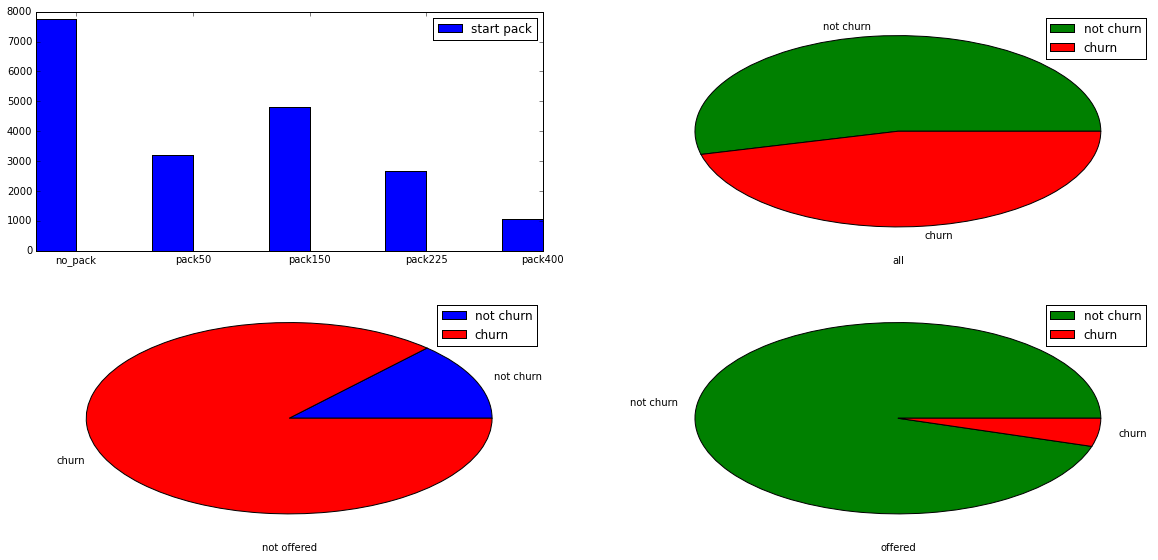

In [104]:
# {'bar', 'barstacked', 'step',  'stepfilled'}
figsize(20,30)
NN=5000
rows = 6
cols =2
i = range(1,cols*rows)
i.reverse()

plt.subplot(rows,cols,i.pop())
index = np.arange(len(intl_pack_labels))
bar_width = 0.35
plt.xticks(index + bar_width, intl_pack_labels)
plt.bar(index, sp.stats.itemfreq(df_raw.intl_package)[:,1].astype(int),bar_width,label='start pack')
plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.pie(np.histogram(churn, bins=2)[0], labels=['not churn', 'churn'], colors=['g','r'])
plt.xlabel("all")
plt.legend(loc='upper right')

plt.subplot(rows,cols,i.pop())
plt.pie(np.histogram(churn[~offered], bins=2)[0], labels=['not churn', 'churn'], colors=['b','r'])
plt.xlabel("not offered")
plt.legend(loc='upper right')

plt.subplot(rows,cols,i.pop())
plt.pie(np.histogram(churn[offered], bins=2)[0], labels=['not churn', 'churn'], colors=['g','r'])
plt.xlabel("offered")
plt.legend(loc='upper right')




# plt.subplot(rows,cols,i.pop())
# plt.hist(pack_offer,50,label='after pack')
# plt.legend(loc='lower right')



In [107]:
X_test[0]

array([   1.        ,  148.34532339,    0.        ,    0.        ,
          1.        ,    0.        ,    0.        ,    0.        ,
          0.        ,  148.34532339,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ])

##OTHER

In [58]:
print sc.stats.stats.pearsonr(X_test, Y_test)
# print np.corrcoef(X_test[:,0], Y_test)

ValueError: operands could not be broadcast together with shapes (4875,22) (4875,) 

In [25]:
for i in range(0,int(len(X_test)*0.001)):    
    print Y_test[i], logreg.predict(X_test[i]), logreg.predict_proba(X_test[i])

0.0 [ 0.] [[ 0.99841225  0.00158775]]
1.0 [ 0.] [[ 0.79730005  0.20269995]]
0.0 [ 0.] [[ 0.99618579  0.00381421]]
0.0 [ 0.] [[ 0.84255979  0.15744021]]


In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_train.shape

# X_train = SelectKBest(chi2, k=2).fit_transform(X_train, Y_train)
X_train.shape
X_train

array([[   1.        ,  133.19766043,    1.        , ...,    0.        ,
           0.        ,    0.        ],
       [   1.        ,   62.56541367,    1.        , ...,    0.        ,
           0.        ,    0.        ],
       [   1.        ,  137.80720216,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       ..., 
       [   1.        ,   99.97667425,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   1.        ,  142.65939681,    1.        , ...,    0.        ,
           0.        ,    0.        ],
       [   1.        ,  176.42611233,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

In [27]:
logreg.score(X_train, Y_train)

0.96109401709401709

In [28]:
 Y_train.mean(), Y_test.mean()

(0.4622222222222222, 0.45743589743589741)

In [29]:
grid = gs.GridSearchCV(logreg, {'C': np.logspace(-5, 5, 200)}, n_jobs=4)
grid.fit(X_train, Y_train);
grid.best_params_
# cv.cross_val_score(grid.best_estimator_, X_train, Y_train)

{'C': 6.0102767820703882}

In [30]:
plt.figure(figsize=(100, 20));
vstack = np.vstack((np.ravel(df_Y_test.is_churn.astype(float))[0:50], y_predicted.astype(float)[0:50]))
plt.imshow(vstack, interpolation='none', cmap='bone');
# plt.imshow(np.vstack(([1,0,1,0], [1,0,1,1])), interpolation='none', cmap='bone');
plt.xticks([]); plt.yticks([]);
plt.title(("Actual and predicted survival outcomes on the test set"));

NameError: name 'df_Y_test' is not defined

In [ ]:
enc = preprocessing.OneHotEncoder(n_values=len(intl_pack_ids))
# enc.fit(df_raw.package_offer.values.astype(int))
print enc.transform([df_raw.package_offer.values.astype(int)])

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_raw.package_offer.values)
le.transform(df_raw.package_offer.values)